In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
import pandas as pd
from utils.evaluation import MetaQA_Dataset
from utils.graph import KGraphPreproc
import matplotlib.pyplot as plt
from utils.preprocessing import preprocess_text
import networkx as nx
import ast

In [11]:
metaqa_eval = MetaQA_Dataset()

In [12]:
metaqa_eval.tabulate_performance()

MetaQA
+-----------+----------+--------+--------+
| Method    |     1hop |   2hop |   3hop |
+===========+==========+========+========+
| bline     | 0.388    |  0.222 |  0.398 |
+-----------+----------+--------+--------+
| kb-path   | 0.972    |  0.974 |  0.981 |
+-----------+----------+--------+--------+
| kb1       | 0.88     |  0.166 |  0.341 |
+-----------+----------+--------+--------+
| kb2       | 0.841    |  0.739 |  0.358 |
+-----------+----------+--------+--------+
| kb3       | 0.834835 |  0.185 |  0.319 |
+-----------+----------+--------+--------+
| kb4       | 0.287    |  0.181 |  0.318 |
+-----------+----------+--------+--------+
| sbert-kb1 | 0.854    |  0.168 |  0.356 |
+-----------+----------+--------+--------+
| sbert-kb2 | 0.86     |  0.733 |  0.357 |
+-----------+----------+--------+--------+
| sbert-kb3 | 0.801    |  0.514 |  0.313 |
+-----------+----------+--------+--------+
| tog-pl-1  | 0        |  0     |  0.205 |
+-----------+----------+--------+--------+


In [13]:
mqa_graph = KGraphPreproc.get_metaqa_graph()

In [14]:
import re
regex_mqa_topic_entity = re.compile("\[(.*?)\]")
def extract_mqa_topic_entity(question):
    return regex_mqa_topic_entity.findall(question)[0]

In [15]:
mqa = pd.DataFrame(columns=["id", "hop", "Question", "topic_entity", "Answers"])
mqa

,id,hop,Question,topic_entity,Answers


In [16]:
hops = [1,2,3]
for hop in hops:
    test_set_path = f"/datasets/MetaQA/{hop}hop/test_1000.txt"
    tset = pd.read_csv(test_set_path, header=None, index_col="qid", names=["qid", "Question", "Answers"])
    tset.rename(columns={0: "Question", 1: "Answers"}, inplace=True)
    tset["topic_entity"] = tset.Question.apply(extract_mqa_topic_entity)
    tset["Answer"] = tset.apply(lambda t: list(set(t.Answers.lower().split("|"))), axis=1)
    tset = tset.explode("Answer")
    # tset["Answer"] = tset.Answer.apply(preprocess_text)
    tset["id"] = tset.apply(lambda r: f"{hop}-{r.name}", axis=1)
    tset["hop"] = hop
    print(tset.columns)
    mqa = pd.concat([mqa, tset])
mqa.dropna(inplace=True)
print("Total unique question-answer pairs:", len(mqa))

Index(['Question', 'Answers', 'topic_entity', 'Answer', 'id', 'hop'], dtype='object')
Index(['Question', 'Answers', 'topic_entity', 'Answer', 'id', 'hop'], dtype='object')
Index(['Question', 'Answers', 'topic_entity', 'Answer', 'id', 'hop'], dtype='object')
Total unique question-answer pairs: 21455


In [134]:
mqa.columns

Index(['id', 'hop', 'Question', 'topic_entity', 'Answers', 'Answer'], dtype='object')

In [ ]:
mqa["path"] = mqa.apply(
    lambda r: nx.shortest_path(
        mqa_graph._graph,
        mqa_graph.name2mid[r["topic_entity"]],
        mqa_graph.preprocessed_nodes.get(r.Answer, None)
    ),
    axis=1
)

In [ ]:
mqa.drop_duplicates(["Question", "topic_entity", "Answer"], inplace=True)
mqa.head(2)

,id,hop,Question,topic_entity,Answers,Answer,path
3710,1-3710,1,who is the director that directed [Big Jake],Big Jake,John Wayne|George Sherman,georg sherman,"[40638, 4025]"
3710,1-3710,1,who is the director that directed [Big Jake],Big Jake,John Wayne|George Sherman,john wayn,"[40638, 2948]"


In [109]:
mqa["hops"] = mqa.path.apply(len)
mqa

AttributeError: 'DataFrame' object has no attribute 'path'

In [106]:
mqa.columns

Index(['id', 'hop', 'Question', 'topic_entity', 'Answers', 'Answer', 'bline',
       'bline_rouge-l', 'bline_correct', 'kb-path', 'kb-path_rouge-l',
       'kb-path_correct', 'kb1', 'kb1_rouge-l', 'kb1_correct', 'kb2',
       'kb2_rouge-l', 'kb2_correct', 'kb3', 'kb3_rouge-l', 'kb3_correct',
       'kb4', 'kb4_rouge-l', 'kb4_correct', 'sbert-kb1', 'sbert-kb1_rouge-l',
       'sbert-kb1_correct', 'sbert-kb2', 'sbert-kb2_rouge-l',
       'sbert-kb2_correct', 'sbert-kb3', 'sbert-kb3_rouge-l',
       'sbert-kb3_correct'],
      dtype='object')

In [169]:
mqa.drop(columns=['bline'], inplace=True)

In [163]:
mqa.drop(columns=['bline', 'kb-path', 'kb1', 'kb2', 'kb3', 'sbert-kb1', 'sbert-kb2',
       'sbert-kb3'], inplace=True)

KeyError: "['kb-path', 'kb1', 'kb2', 'kb3', 'sbert-kb1', 'sbert-kb2', 'sbert-kb3'] not found in axis"

In [107]:
metaqa_eval.result_set_paths

['/datasets/MetaQA/results/{hop}/bline.csv',
 '/datasets/MetaQA/results/{hop}/kb-path.csv',
 '/datasets/MetaQA/results/{hop}/kb1.csv',
 '/datasets/MetaQA/results/{hop}/kb2.csv',
 '/datasets/MetaQA/results/{hop}/kb3.csv',
 '/datasets/MetaQA/results/{hop}/kb4.csv',
 '/datasets/MetaQA/results/{hop}/sbert-kb1.csv',
 '/datasets/MetaQA/results/{hop}/sbert-kb2.csv',
 '/datasets/MetaQA/results/{hop}/sbert-kb3.csv',
 '/datasets/MetaQA/results/{hop}/tog-pl-1.csv']

In [ ]:
for r_set in metaqa_eval.result_set_paths:
    set_name = r_set.split("/")[-1].split(".")[0]
    print(set_name)
    for hop in [1,2,3]:
        print(hop)
        results_df = pd.read_csv(r_set.format(hop=f"{hop}hop"), index_col=0)
        results_df.rename(columns={"Model": set_name}, inplace=True)
        # print("b", mqa.columns)
        mqa = mqa.merge(results_df, how="left", left_index=True, right_index=True)
        # print("a", mqa.columns)
        if (set_name+"_x" in mqa) and (set_name+"_y" in mqa):
            mqa[set_name] = mqa[set_name+"_x"].combine_first(mqa[set_name+"_y"])
            mqa.drop(columns=[set_name+"_x", set_name+"_y"], inplace=True)
    mqa.fillna("", inplace=True)
    mqa[set_name] = mqa.apply(lambda t: set(t[set_name].lower().split("|")), axis=1).values
    # compute rouge-match and correctness
    # print(result_df)
    mqa[set_name+"_rouge-l"] = mqa.apply(lambda t: metaqa_eval.get_rouge_score_for_answers(t.Answer, t[set_name]), axis=1)
    mqa[set_name+"_correct"] = mqa.apply(lambda t: t[set_name+"_rouge-l"] >= 0.5, axis=1)
    

bline
1
2
3


AttributeError: 'set' object has no attribute 'lower'

In [60]:
set_names = [r.split("/")[-1].split(".")[0] for r in metaqa_eval.result_set_paths]
set_names

['bline',
 'kb-path',
 'kb1',
 'kb2',
 'kb3',
 'kb4',
 'sbert-kb1',
 'sbert-kb2',
 'sbert-kb3']

In [61]:
mqa_res = mqa[["hop", *[s+"_correct" for s in set_names]]]
mqa_res.head()

,hop,bline_correct,kb-path_correct,kb1_correct,kb2_correct,kb3_correct,kb4_correct,sbert-kb1_correct,sbert-kb2_correct,sbert-kb3_correct
3710,1,True,True,True,True,False,False,True,True,True
5313,1,False,True,True,False,False,False,True,False,False
5479,1,False,False,True,False,True,False,True,True,True
1253,1,False,True,True,True,True,False,True,True,True
9668,1,False,True,True,True,True,False,True,True,True


In [62]:
hop_stats = mqa_res.groupby(by="hop").sum()
hop_stats["total"] = mqa_res.groupby(by="hop").apply(lambda t: len(t))
for rset in set_names:
    hop_stats[f"{rset}_p"] = round(hop_stats[f"{rset}_correct"] / hop_stats["total"], 3)
hop_stats

/tmp/ipykernel_4151/1529986411.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hop_stats["total"] = mqa_res.groupby(by="hop").apply(lambda t: len(t))


,bline_correct,kb-path_correct,kb1_correct,kb2_correct,kb3_correct,kb4_correct,sbert-kb1_correct,sbert-kb2_correct,sbert-kb3_correct,total,bline_p,kb-path_p,kb1_p,kb2_p,kb3_p,kb4_p,sbert-kb1_p,sbert-kb2_p,sbert-kb3_p
hop,,,,,,,,,,,,,,,,,,,
1,388,972,880,841,834,287,854,860,801,1000,0.388,0.972,0.880,0.841,0.834,0.287,0.854,0.860,0.801
2,199,870,150,661,174,169,151,655,465,1000,0.199,0.870,0.150,0.661,0.174,0.169,0.151,0.655,0.465
3,299,696,258,253,246,250,267,268,239,1000,0.299,0.696,0.258,0.253,0.246,0.250,0.267,0.268,0.239


In [66]:
print("MetaQA")
data = hop_stats[["total", *[s+"_p" for s in set_names]]]
data

MetaQA


,total,bline_p,kb-path_p,kb1_p,kb2_p,kb3_p,kb4_p,sbert-kb1_p,sbert-kb2_p,sbert-kb3_p
hop,,,,,,,,,,
1,1000,0.388,0.972,0.880,0.841,0.834,0.287,0.854,0.860,0.801
2,1000,0.199,0.870,0.150,0.661,0.174,0.169,0.151,0.655,0.465
3,1000,0.299,0.696,0.258,0.253,0.246,0.250,0.267,0.268,0.239


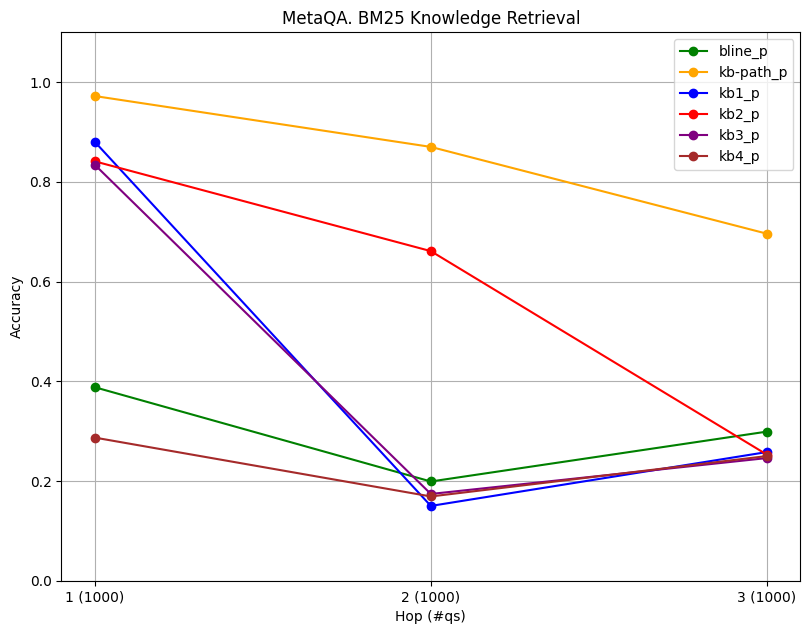

In [69]:
colors = {
    "bline_p": "green",
    "kb-path_p": "orange",
    "kb1_p": "blue",
    "kb2_p": "red",
    "kb3_p": "purple",
    "kb4_p": "brown",
    # "kb5_p": "pink",
    # "kb6_p": "olive",
    # "n-1": "blue",
    # "n": "red",
    # "n+1": "purple",
}

fig, ax = plt.subplots(figsize=(8, 6))

datas = {
    "bline_p": data["bline_p"].values,
    "kb-path_p": data["kb-path_p"].values,
    "kb1_p": data["kb1_p"],
    "kb2_p": data["kb2_p"],
    "kb3_p": data["kb3_p"],
    "kb4_p": data["kb4_p"],
}
for j,k in enumerate(datas.keys()):
    ax.plot(
        data.index.values.astype(int), datas[k],
        color=colors[k], label=k, marker="o",
         
    )
plt.xticks(data.index.values.astype(int), [f"{i} ({data.loc[i, 'total']})" for i in data.index.values])

ax.set_ylim(0, 1.1)
plt.tight_layout(pad=1)
plt.title("MetaQA. BM25 Knowledge Retrieval")
plt.xlabel("Hop (#qs)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Display the plot
plt.show()


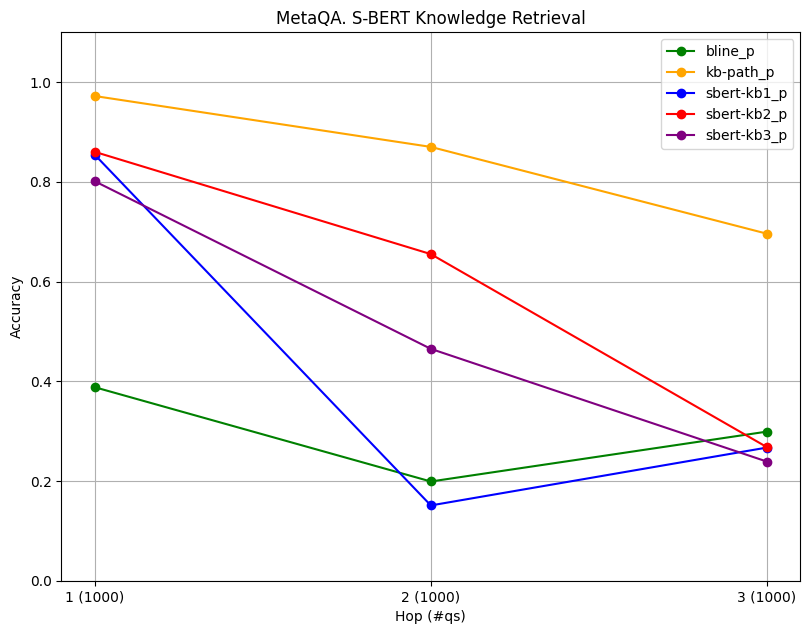

In [ ]:
colors = {
    "bline_p": "green",
    "kb-path_p": "orange",
    "sbert-kb1_p": "blue",
    "sbert-kb2_p": "red",
    "sbert-kb3_p": "purple",
    "sbert-kb4_p": "brown",
    # "kb5_p": "pink",
    # "kb6_p": "olive",
    # "n-1": "blue",
    # "n": "red",
    # "n+1": "purple",
}

fig, ax = plt.subplots(figsize=(8, 6))

datas = {
    "bline_p": data["bline_p"].values,
    "kb-path_p": data["kb-path_p"].values,
    "sbert-kb1_p": data["sbert-kb1_p"],
    "sbert-kb2_p": data["sbert-kb2_p"],
    "sbert-kb3_p": data["sbert-kb3_p"],
    # "sbert-kb4_p": data["sbert-kb4_p"],
}
for j,k in enumerate(datas.keys()):
    ax.plot(
        data.index.values.astype(int), datas[k],
        color=colors[k], label=k, marker="o",
         
    )
plt.xticks(data.index.values.astype(int), [f"{i} ({data.loc[i, 'total']})" for i in data.index.values])

ax.set_ylim(0, 1.1)
plt.tight_layout(pad=1)
plt.title("MetaQA. S-BERT Knowledge Retrieval")
plt.xlabel("Hop (#qs)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Display the plot
plt.show()
